In [ ]:
!pip install baselines

In [3]:
#from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [8]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11501568/11490434 [==============================] - 1s 0us/step
Epoch 1/30
547/547 [==============================] - 74s 132ms/step - loss: 254.1606 - reconstruction_loss: 207.8862 - kl_loss: 3.3351
Epoch 2/30
547/547 [==============================] - 70s 129ms/step - loss: 180.6826 - reconstruction_loss: 170.2578 - kl_loss: 5.6217
Epoch 3/30
547/547 [==============================] - 70s 129ms/step - loss: 167.1753 - reconstruction_loss: 159.7286 - kl_loss: 5.8223
Epoch 4/30
547/547 [==============================] - 70s 129ms/step - loss: 161.6971 - reconstruction_loss: 154.7529 - kl_loss: 6.0593
Epoch 5/30
547/547 [==============================] - 71s 129ms/step - loss: 158.6327 - reconstruction_loss: 152.2884 - kl_loss: 6.1097
Epoch 6/30
547/547 [==============================] - 71s 131ms/step - loss: 156.9817 - reconstruction_loss: 150.6803 - kl_loss: 6.1192
Epoch 7/30
547/547 [==============================] - 70s 129ms/step - loss: 155.8381 - reconstruction_loss: 149.4577 -

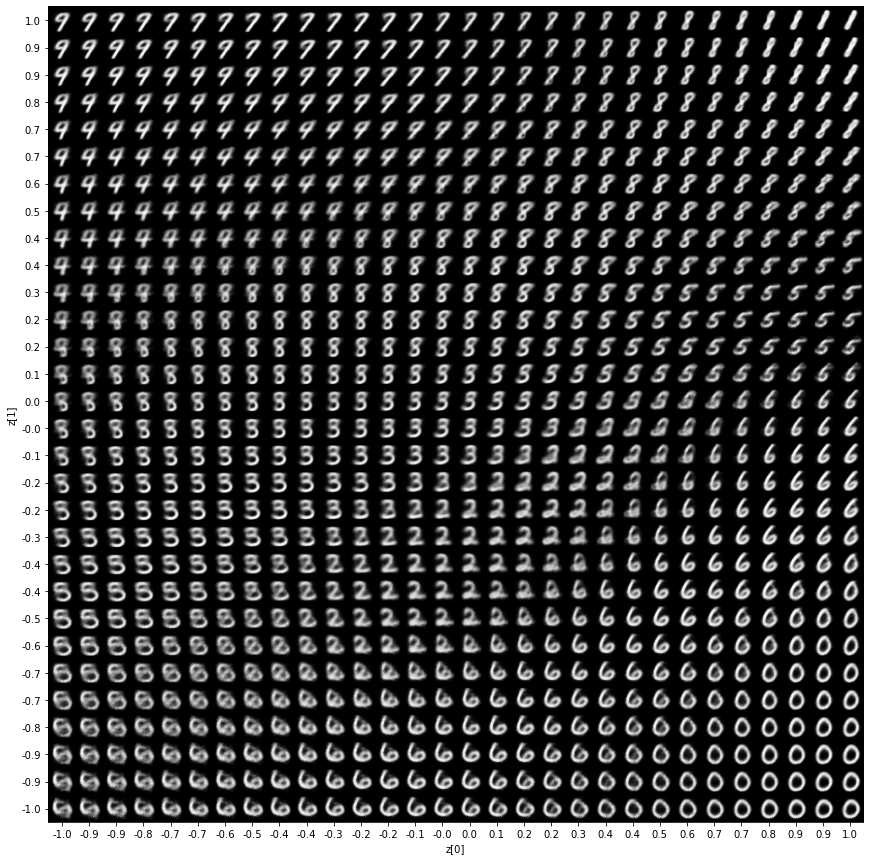

In [9]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

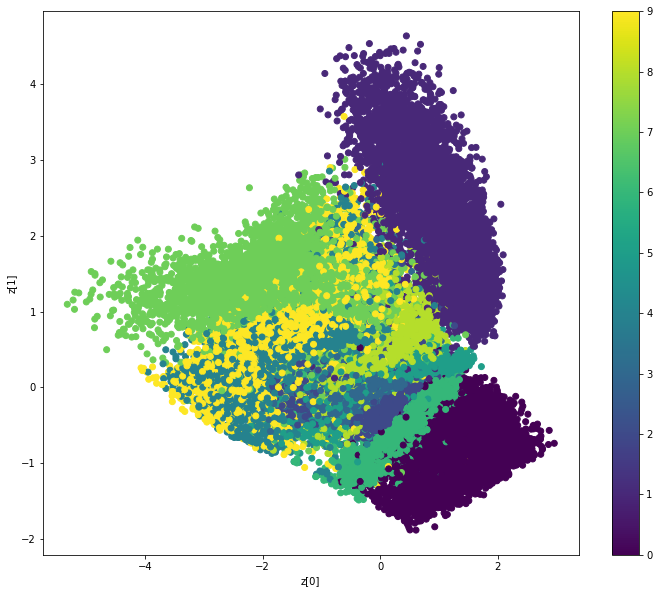

In [10]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

# NVP

In [13]:
pip install -U tensorflow-probability==0.17.0

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied, skipping upgrade: six>=1.10.0 in c:\users\student\anaconda3\lib\site-packages (from tensorflow-probability==0.17.0) (1.15.0)

  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.13.0
    Uninstalling tensorflow-probability-0.13.0:
      Successfully uninstalled tensorflow-probability-0.13.0


In [21]:
pip show tensorflow

Name: tensorflow
Version: 2.9.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\student\anaconda3\lib\site-packages
Requires: six, numpy, tensorboard, typing-extensions, gast, setuptools, tensorflow-io-gcs-filesystem, grpcio, absl-py, h5py, google-pasta, astunparse, flatbuffers, tensorflow-estimator, libclang, keras-preprocessing, packaging, protobuf, keras, termcolor, wrapt, opt-einsum
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [25]:
!pip install --upgrade tensorflow==2.9.0

  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1
  Using cached tensorflow-2.9.0-cp38-cp38-win_amd64.whl (444.1 MB)


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [2]:
data = make_moons(3000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)

In [3]:
# Creating a custom layer with keras API.
output_dim = 256
reg = 0.01


def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])

In [4]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.

        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

In [ ]:
model = RealNVP(num_coupling_layers=6)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

history = model.fit(
    normalized_data, batch_size=256, epochs=300, verbose=2, validation_split=0.2
)

94/94 [==============================] - 2s 9ms/step


(-2.0, 2.0)

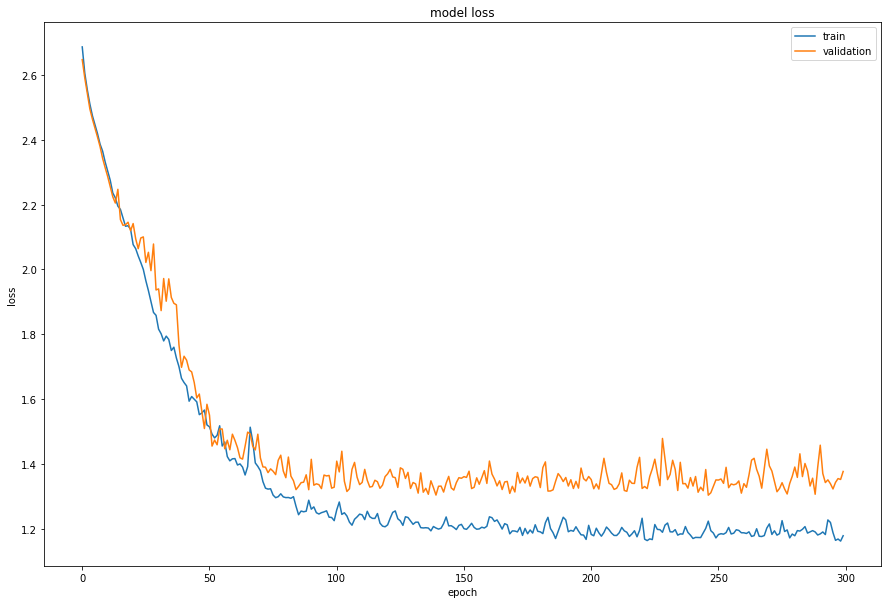

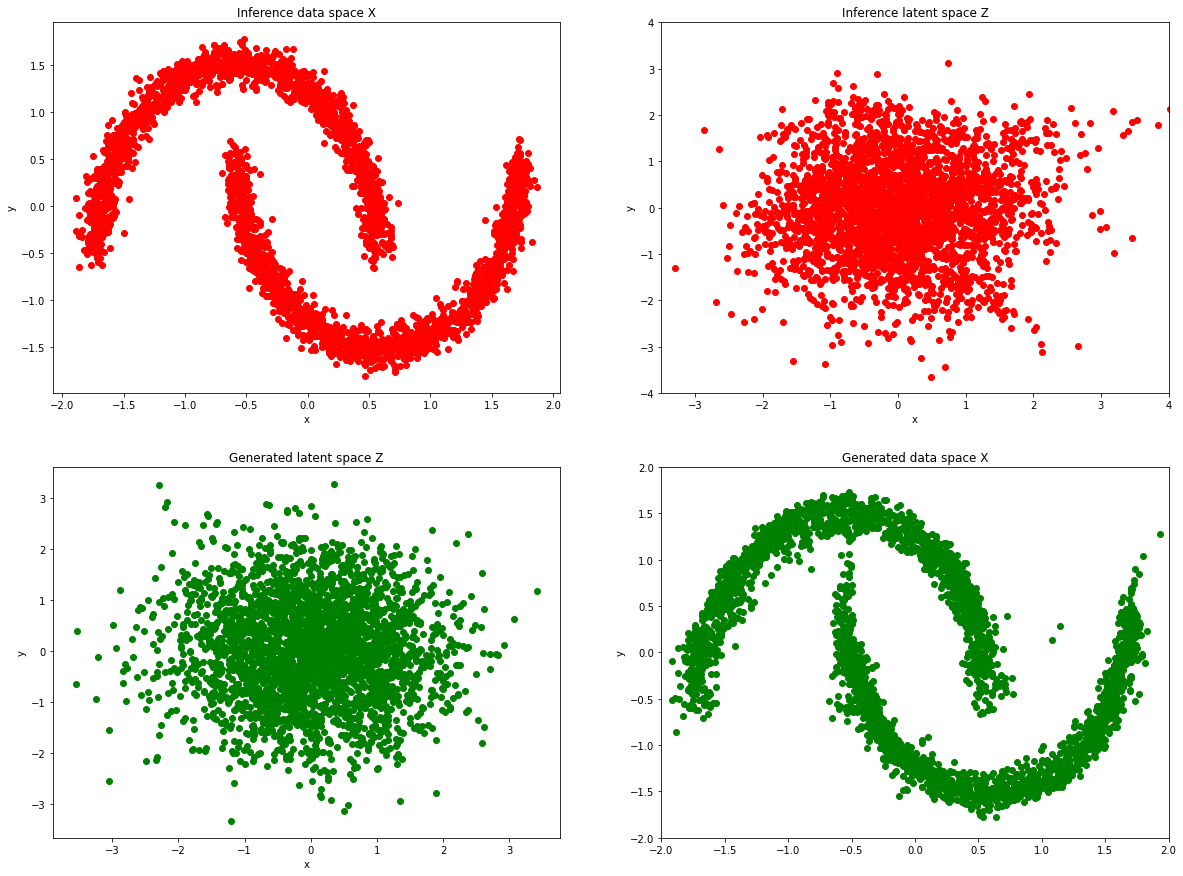

In [6]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = model(normalized_data)

# From latent space to data.
samples = model.distribution.sample(3000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])

# Estimating Sample Size Example

In [2]:
pip install tensorflow_datasets

  Using cached dill-0.3.5.1-py2.py3-none-any.whl (95 kB)

  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21500 sha256=78c97571337146cdcd4e51fb298ee627f6d04a29945dcaf1d2bcea4894d6f41f
  Stored in directory: c:\users\student\appdata\local\pip\cache\wheels\54\aa\01\724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
Successfully built promise


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers

# Define seed and fixed variables
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
AUTO = tf.data.AUTOTUNE

In [2]:
# Specify dataset parameters
dataset_name = "tf_flowers"
batch_size = 64
image_size = (224, 224)

# Load data from tfds and split 10% off for a test set
(train_data, test_data), ds_info = tfds.load(
    dataset_name,
    split=["train[:90%]", "train[90%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Extract number of classes and list of class names
num_classes = ds_info.features["label"].num_classes
class_names = ds_info.features["label"].names

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Convert datasets to NumPy arrays
def dataset_to_array(dataset, image_size, num_classes):
    images, labels = [], []
    for img, lab in dataset.as_numpy_iterator():
        images.append(tf.image.resize(img, image_size).numpy())
        labels.append(tf.one_hot(lab, num_classes))
    return np.array(images), np.array(labels)


img_train, label_train = dataset_to_array(train_data, image_size, num_classes)
img_test, label_test = dataset_to_array(test_data, image_size, num_classes)

num_train_samples = len(img_train)
print(f"Number of training samples: {num_train_samples}")

Number of classes: 5
Class names: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Number of training samples: 3303


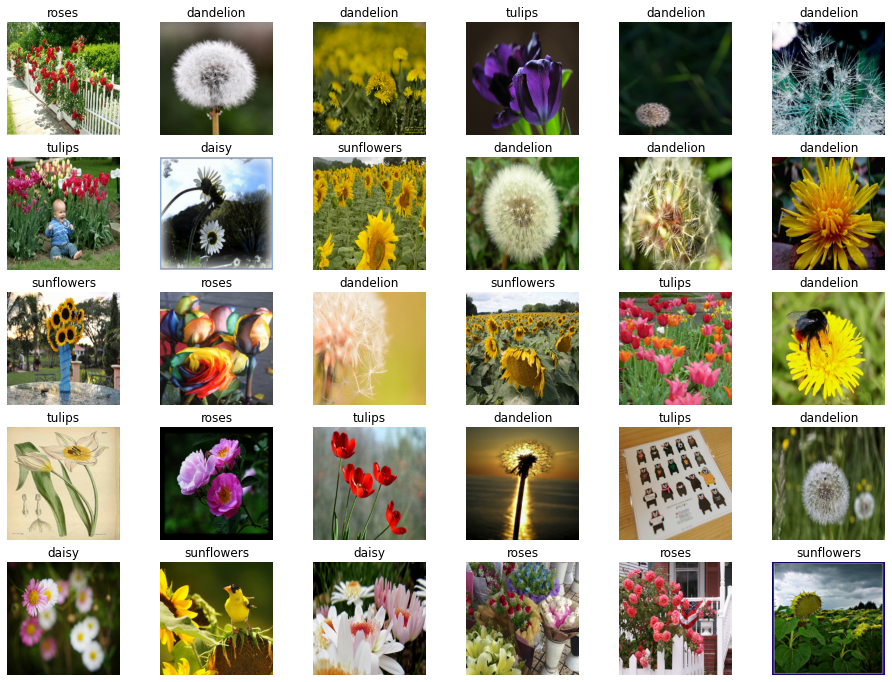

In [3]:
plt.figure(figsize=(16, 12))
for n in range(30):
    ax = plt.subplot(5, 6, n + 1)
    plt.imshow(img_test[n].astype("uint8"))
    plt.title(np.array(class_names)[label_test[n] == True][0])
    plt.axis("off")

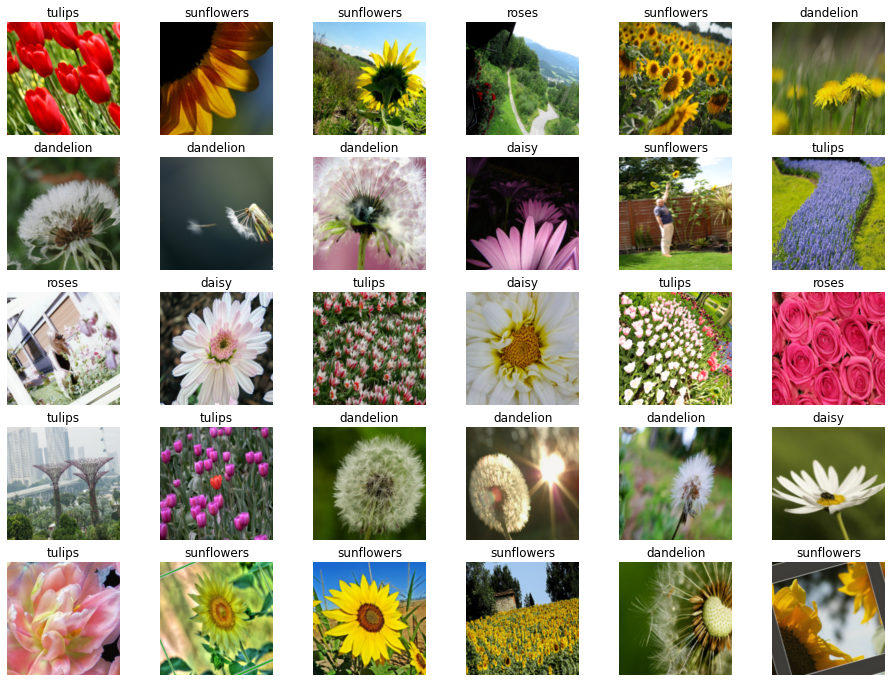

In [4]:
# Define image augmentation model
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomZoom(height_factor=(-0.1, -0)),
        layers.RandomContrast(factor=0.1),
    ],
)

# Apply the augmentations to the training images and plot a few examples
img_train = image_augmentation(img_train).numpy()

plt.figure(figsize=(16, 12))
for n in range(30):
    ax = plt.subplot(5, 6, n + 1)
    plt.imshow(img_train[n].astype("uint8"))
    plt.title(np.array(class_names)[label_train[n] == True][0])
    plt.axis("off")

In [5]:
def build_model(num_classes, img_size=image_size[0], top_dropout=0.3):
    """Creates a classifier based on pre-trained MobileNetV2.

    Arguments:
        num_classes: Int, number of classese to use in the softmax layer.
        img_size: Int, square size of input images (defaults is 224).
        top_dropout: Int, value for dropout layer (defaults is 0.3).

    Returns:
        Uncompiled Keras model.
    """

    # Create input and pre-processing layers for MobileNetV2
    inputs = layers.Input(shape=(img_size, img_size, 3))
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    model = keras.applications.MobileNetV2(
        include_top=False, weights="imagenet", input_tensor=x
    )

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Dropout(top_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    print("Trainable weights:", len(model.trainable_weights))
    print("Non_trainable weights:", len(model.non_trainable_weights))
    return model


def compile_and_train(
    model,
    training_data,
    training_labels,
    metrics=[keras.metrics.AUC(name="auc"), "acc"],
    optimizer=keras.optimizers.Adam(),
    patience=5,
    epochs=5,
):
    """Compiles and trains the model.

    Arguments:
        model: Uncompiled Keras model.
        training_data: NumPy Array, trainig data.
        training_labels: NumPy Array, trainig labels.
        metrics: Keras/TF metrics, requires at least 'auc' metric (default is
                `[keras.metrics.AUC(name='auc'), 'acc']`).
        optimizer: Keras/TF optimizer (defaults is `keras.optimizers.Adam()).
        patience: Int, epochsfor EarlyStopping patience (defaults is 5).
        epochs: Int, number of epochs to train (default is 5).

    Returns:
        Training history for trained Keras model.
    """

    stopper = keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        min_delta=0,
        patience=patience,
        verbose=1,
        restore_best_weights=True,
    )

    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=metrics)

    history = model.fit(
        x=training_data,
        y=training_labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        callbacks=[stopper],
    )
    return history


def unfreeze(model, block_name, verbose=0):
    """Unfreezes Keras model layers.

    Arguments:
        model: Keras model.
        block_name: Str, layer name for example block_name = 'block4'.
                    Checks if supplied string is in the layer name.
        verbose: Int, 0 means silent, 1 prints out layers trainability status.

    Returns:
        Keras model with all layers after (and including) the specified
        block_name to trainable, excluding BatchNormalization layers.
    """

    # Unfreeze from block_name onwards
    set_trainable = False

    for layer in model.layers:
        if block_name in layer.name:
            set_trainable = True
        if set_trainable and not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            if verbose == 1:
                print(layer.name, "trainable")
        else:
            if verbose == 1:
                print(layer.name, "NOT trainable")
    print("Trainable weights:", len(model.trainable_weights))
    print("Non-trainable weights:", len(model.non_trainable_weights))
    return model

In [6]:
def train_model(training_data, training_labels):
    """Trains the model as follows:

    - Trains only the top layers for 10 epochs.
    - Unfreezes deeper layers.
    - Train for 20 more epochs.

    Arguments:
        training_data: NumPy Array, trainig data.
        training_labels: NumPy Array, trainig labels.

    Returns:
        Model accuracy.
    """

    model = build_model(num_classes)

    # Compile and train top layers
    history = compile_and_train(
        model,
        training_data,
        training_labels,
        metrics=[keras.metrics.AUC(name="auc"), "acc"],
        optimizer=keras.optimizers.Adam(),
        patience=3,
        epochs=10,
    )

    # Unfreeze model from block 10 onwards
    model = unfreeze(model, "block_10")

    # Compile and train for 20 epochs with a lower learning rate
    fine_tune_epochs = 20
    total_epochs = history.epoch[-1] + fine_tune_epochs

    history_fine = compile_and_train(
        model,
        training_data,
        training_labels,
        metrics=[keras.metrics.AUC(name="auc"), "acc"],
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        patience=5,
        epochs=total_epochs,
    )

    # Calculate model accuracy on the test set
    _, _, acc = model.evaluate(img_test, label_test)
    return np.round(acc, 4)

In [7]:
def train_iteratively(sample_splits=[0.05, 0.1, 0.25, 0.5], iter_per_split=5):
    """Trains a model iteratively over several sample splits.

    Arguments:
        sample_splits: List/NumPy array, contains fractions of the trainins set
                        to train over.
        iter_per_split: Int, number of times to train a model per sample split.

    Returns:
        Training accuracy for all splits and iterations and the number of samples
        used for training at each split.
    """
    # Train all the sample models and calculate accuracy
    train_acc = []
    sample_sizes = []

    for fraction in sample_splits:
        print(f"Fraction split: {fraction}")
        # Repeat training 3 times for each sample size
        sample_accuracy = []
        num_samples = int(num_train_samples * fraction)
        for i in range(iter_per_split):
            print(f"Run {i+1} out of {iter_per_split}:")
            # Create fractional subsets
            rand_idx = np.random.randint(num_train_samples, size=num_samples)
            train_img_subset = img_train[rand_idx, :]
            train_label_subset = label_train[rand_idx, :]
            # Train model and calculate accuracy
            accuracy = train_model(train_img_subset, train_label_subset)
            print(f"Accuracy: {accuracy}")
            sample_accuracy.append(accuracy)
        train_acc.append(sample_accuracy)
        sample_sizes.append(num_samples)
    return train_acc, sample_sizes


# Running the above function produces the following outputs
train_acc = [
    [0.8202, 0.7466, 0.8011, 0.8447, 0.8229],
    [0.861, 0.8774, 0.8501, 0.8937, 0.891],
    [0.891, 0.9237, 0.8856, 0.9101, 0.891],
    [0.8937, 0.9373, 0.9128, 0.8719, 0.9128],
]

sample_sizes = [165, 330, 825, 1651]

Curve fit weights: a = 0.6445640325546265 and b = 0.04809745401144028.
A model accuracy of 0.9517362117767334 is predicted for 3303 samples.


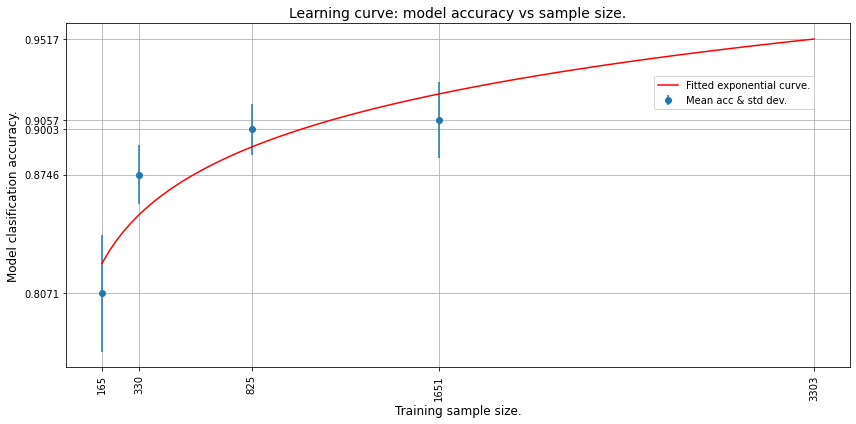

The mae for the curve fit is 0.016098752617836.


In [8]:
def fit_and_predict(train_acc, sample_sizes, pred_sample_size):
    """Fits a learning curve to model training accuracy results.

    Arguments:
        train_acc: List/Numpy Array, training accuracy for all model
                    training splits and iterations.
        sample_sizes: List/Numpy array, number of samples used for training at
                    each split.
        pred_sample_size: Int, sample size to predict model accuracy based on
                        fitted learning curve.
    """
    x = sample_sizes
    mean_acc = [np.mean(i) for i in train_acc]
    error = [np.std(i) for i in train_acc]

    # Define mean squared error cost and exponential curve fit functions
    mse = keras.losses.MeanSquaredError()

    def exp_func(x, a, b):
        return a * x ** b

    # Define variables, learning rate and number of epochs for fitting with TF
    a = tf.Variable(0.0)
    b = tf.Variable(0.0)
    learning_rate = 0.01
    training_epochs = 5000

    # Fit the exponential function to the data
    for epoch in range(training_epochs):
        with tf.GradientTape() as tape:
            y_pred = exp_func(x, a, b)
            cost_function = mse(y_pred, mean_acc)
        # Get gradients and compute adjusted weights
        gradients = tape.gradient(cost_function, [a, b])
        a.assign_sub(gradients[0] * learning_rate)
        b.assign_sub(gradients[1] * learning_rate)
    print(f"Curve fit weights: a = {a.numpy()} and b = {b.numpy()}.")

    # We can now estimate the accuracy for pred_sample_size
    max_acc = exp_func(pred_sample_size, a, b).numpy()

    # Print predicted x value and append to plot values
    print(f"A model accuracy of {max_acc} is predicted for {pred_sample_size} samples.")
    x_cont = np.linspace(x[0], pred_sample_size, 100)

    # Build the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.errorbar(x, mean_acc, yerr=error, fmt="o", label="Mean acc & std dev.")
    ax.plot(x_cont, exp_func(x_cont, a, b), "r-", label="Fitted exponential curve.")
    ax.set_ylabel("Model clasification accuracy.", fontsize=12)
    ax.set_xlabel("Training sample size.", fontsize=12)
    ax.set_xticks(np.append(x, pred_sample_size))
    ax.set_yticks(np.append(mean_acc, max_acc))
    ax.set_xticklabels(list(np.append(x, pred_sample_size)), rotation=90, fontsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_title("Learning curve: model accuracy vs sample size.", fontsize=14)
    ax.legend(loc=(0.75, 0.75), fontsize=10)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()

    # The mean absolute error (MAE) is calculated for curve fit to see how well
    # it fits the data. The lower the error the better the fit.
    mae = keras.losses.MeanAbsoluteError()
    print(f"The mae for the curve fit is {mae(mean_acc, exp_func(x, a, b)).numpy()}.")


# We use the whole training set to predict the model accuracy
fit_and_predict(train_acc, sample_sizes, pred_sample_size=num_train_samples)

In [9]:
# Now train the model with full dataset to get the actual accuracy
accuracy = train_model(img_train, label_train)
print(f"A model accuracy of {accuracy} is reached on {num_train_samples} images!")

Trainable weights: 2
Non_trainable weights: 260
Epoch 1/10
47/47 [==============================] - 84s 2s/step - loss: 1.1305 - auc: 0.8365 - acc: 0.5690 - val_loss: 0.5193 - val_auc: 0.9723 - val_acc: 0.8097
Epoch 2/10
47/47 [==============================] - 79s 2s/step - loss: 0.5698 - auc: 0.9591 - acc: 0.8011 - val_loss: 0.3800 - val_auc: 0.9851 - val_acc: 0.8792
Epoch 3/10
47/47 [==============================] - 79s 2s/step - loss: 0.4574 - auc: 0.9735 - acc: 0.8402 - val_loss: 0.3441 - val_auc: 0.9869 - val_acc: 0.8671
Epoch 4/10
47/47 [==============================] - 87s 2s/step - loss: 0.4007 - auc: 0.9794 - acc: 0.8573 - val_loss: 0.3077 - val_auc: 0.9897 - val_acc: 0.8792
Epoch 5/10
47/47 [==============================] - 87s 2s/step - loss: 0.3579 - auc: 0.9830 - acc: 0.8755 - val_loss: 0.3003 - val_auc: 0.9897 - val_acc: 0.8822
Epoch 6/10
47/47 [==============================] - 85s 2s/step - loss: 0.3332 - auc: 0.9859 - acc: 0.8883 - val_loss: 0.2915 - val_auc: 0.990